In [1]:
import cv2
import toml
import sys
import os
from IPython.display import display, Image

sys.path.append(os.path.abspath("data_management"))
sys.path.append(os.path.abspath("onnx_models"))

import data_preprocessing as dprep
import data_postprocessing as dpostp
import onnx_inference as onnx_inf

%matplotlib inline

In [2]:
yolo_cfg = toml.load('yolov5n.toml')
imgsz = yolo_cfg['input_data']['imgsz']
conf_thres = yolo_cfg['predictor']['conf_thres']
iou_thres = yolo_cfg['predictor']['iou_thres']
classes = yolo_cfg['predictor']['classes']
if not classes:
    classes = None
onnx_model_path = yolo_cfg['onnx_model_path']
visualize = yolo_cfg['visualize']
out_img_path = yolo_cfg['out_img_path']
input_source = yolo_cfg['source']

In [3]:
stride, names, session, output_names = onnx_inf.load_model(onnx_model_path)

name 'cap' is not defined


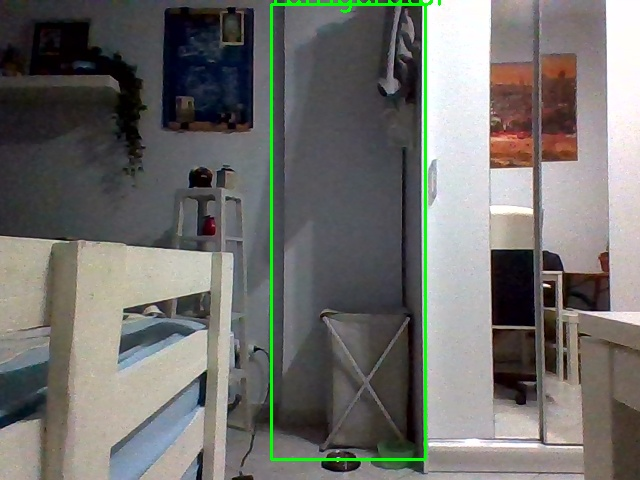

{'object': 'refrigerator', 'x': 266, 'y': 5, 'width': 159, 'height': 450}
{'object': 'refrigerator', 'x': 264, 'y': 5, 'width': 162, 'height': 451}
{'object': 'refrigerator', 'x': 269, 'y': 4, 'width': 159, 'height': 451}
{'object': 'refrigerator', 'x': 43, 'y': 8, 'width': 380, 'height': 441}
{'object': 'refrigerator', 'x': 270, 'y': 6, 'width': 154, 'height': 443}
{'object': 'refrigerator', 'x': 56, 'y': 11, 'width': 369, 'height': 439}
{'object': 'refrigerator', 'x': 266, 'y': 4, 'width': 160, 'height': 451}
{'object': 'chair', 'x': 549, 'y': 111, 'width': 91, 'height': 256}
{'object': 'chair', 'x': 538, 'y': 113, 'width': 102, 'height': 356}
{'object': 'chair', 'x': 498, 'y': 109, 'width': 140, 'height': 350}
{'object': 'chair', 'x': 506, 'y': 108, 'width': 133, 'height': 359}
{'object': 'chair', 'x': 486, 'y': 84, 'width': 154, 'height': 386}
{'object': 'refrigerator', 'x': 266, 'y': 4, 'width': 159, 'height': 450}
{'object': 'person', 'x': 464, 'y': 7, 'width': 175, 'height': 467

KeyboardInterrupt: 

In [4]:
try:
    cap.release()
    cap.destroyAllWindows()
except Exception as e:
    print(e)
    pass

if input_source == 'webcam':
    cap = cv2.VideoCapture(0) 
    display_handle=display(None, display_id=True)
else:
    cap = cv2.VideoCapture(input_source)

frame_count = 0
while(cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Check that frame is not empty
    if ret:
        orig_img = frame.copy()
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        img = dprep.img_preprocess(img, imgsz, stride)

        predictions = onnx_inf.model_inf(img, session, output_names)

        predictions = dpostp.yolo_nms(predictions, conf_thres, iou_thres, classes)

        for pred in predictions:

            pred[:, :4] = dpostp.scale_boxes((imgsz, imgsz), pred[:, :4], orig_img.shape).round()

            for p in pred:
                print({"object":names[int(p[5])], "x":int(p[0]), "y":int(p[1]), "width":int(p[2])-int(p[0]), "height":int(p[3])-int(p[1])})

                if visualize:
                    cv2.rectangle(orig_img, (int(p[0]), int(p[1])), (int(p[2]), int(p[3])), (0, 255, 0), 2)
                    cv2.putText(orig_img, names[int(p[5])], (int(p[0]), int(p[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        if visualize:
            # cv2.imwrite(os.path.join(out_img_path, f'{frame_count}.png'), orig_img)
            _, disp_img = cv2.imencode('.jpeg', orig_img)
            display_handle.update(Image(data=disp_img.tobytes()))
            frame_count += 1

    else:
        break
        
try:
    cap.release()
    cap.destroyAllWindows()
    display_handle.update(None)
except Exception as e:
    print(e)
    pass